# RAPA MVP Description

With RAPA, we plan to provide a robust, freely usable, and shareable tool for automated parsimony analysis.

RAPA will initially be developed on top of DataRobot’s Python API to use DataRobot as a "model-running engine." In the RAPA MVP, we will provide two primary features:

* Initial feature filtering to reduce a feature list down to a size that DataRobot can receive as input.

* Automated parsimony analysis to present to the user the trade-off between the size of Feature List and the best model performance on each Feature List, presented as a Pareto front.

Although the MVP implementation of these features will be based on basic techniques such as linear feature filters and recursive feature elimination, we plan to rapidly improve these features by integrating state-of-the-art techniques from the academic literature.

DataRobot API reference: https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.23.0/autodoc/api_reference.html

**The implementation below represents a quick first prototype that implements the core RAPA features.**

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import pickle
import time
from collections import defaultdict

from tqdm.notebook import tqdm

from sklearn.feature_selection import f_regression, f_classif
from sklearn.model_selection import StratifiedKFold, KFold
import datarobot as dr

pd.set_option('mode.chained_assignment', None)

In [2]:
datarobot_tokens = pickle.load(open('demo-data/dr-tokens.p', 'rb'))

dr.Client(endpoint='https://app.datarobot.com/api/v2',
          token=datarobot_tokens['RANDY'])

print('DataRobot API initiated')

DataRobot API initiated


In [3]:
def create_datarobot_classification_submission(input_data_df, target_name, max_features=19990, n_splits=6,
                                               filter_function=f_classif, random_state=None):
    """Prepares the input data for submission as a classification project on DataRobot.

    Creates pre-determined k-fold cross-validation splits and filters the feature
    set down to a size that DataRobot can receive as input, if necessary.

    Parameters
    ----------
    input_data_df: pandas.DataFrame
        pandas DataFrame containing the feature set and prediction target.

    target_name: str
        Name of the prediction target column in `input_data_df`.

    max_features: int, optional (default: 19990)
        The number of features to reduce the feature set in `input_data_df`
        down to. DataRobot's maximum feature set size is 20,000.

    n_splits: int, optional (default: 6)
        The number of stratified cross-validation splits to create. One of the splits
        will be retained as a holdout split, so by default this function
        sets up the dataset for 5-fold cross-validation with a holdout.

    filter_function: callable, optional (default: sklearn.feature_selection.f_classif)
        The function used to calculate the importance of each feature in
        the initial filtering step that reduces the feature set down to
        `max_features`.

        This filter function must take a feature matrix as the first input
        and the target array as the second input, then return two separate
        arrays containing the feature importance of each feature and the
        P-value for that correlation, in that order.

        See scikit-learn's f_classif function for an example:
        https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html

    random_state: int, optional (default: None)
        The random number generator seed for RAPA. Use this parameter to make sure
        that RAPA will give you the same results each time you run it on the
        same input data set with that seed.

    """
    input_data_df = input_data_df.copy()
    only_features_df = input_data_df.drop(columns=[target_name])
        
    kfold_type = StratifiedKFold

    if len(np.unique(input_data_df[target_name].values)) == 2:
        target_type = dr.enums.TARGET_TYPE.BINARY
    else:
        target_type = dr.enums.TARGET_TYPE.MULTICLASS

    input_data_df['partition'] = 'train'
    train_feature_importances = []
    for fold_num, (_, fold_indices) in enumerate(
        kfold_type(n_splits=n_splits, random_state=random_state, shuffle=True).split(only_features_df.values,
                                                                                     input_data_df[target_name].values)):
        input_data_df['partition'].iloc[fold_indices] = 'CV Fold {}'.format(fold_num)

        # Fold 0 is the holdout set, so don't calculate feature importances using that fold
        if fold_num > 0:
            feature_importances, _ = filter_function(only_features_df.iloc[fold_indices].values,
                                                     input_data_df[target_name].iloc[fold_indices].values)
            train_feature_importances.append(feature_importances)

    # We calculate the overall feature importance scores by averaging the feature importance scores
    # across all of the training folds
    avg_train_feature_importances = np.mean(train_fvals, axis=0)

    input_data_df.loc[input_data_df['partition'] == 'CV Fold 0', 'partition'] = 'Holdout'

    most_correlated_features = only_features_df.columns.values[np.argsort(avg_train_feature_importances)[::-1][:max_features]].tolist()

    datarobot_upload_df = input_data_df[[target_name, 'partition'] + most_correlated_features]

    return datarobot_upload_df, target_type


def create_datarobot_regression_submission(input_data_df, target_name, max_features=19900, n_splits=6,
                                           filter_function=f_regression, random_state=None):
    """Prepares the input data for submission as a regression project on DataRobot.

    Creates pre-determined k-fold cross-validation splits and filters the feature
    set down to a size that DataRobot can receive as input, if necessary.

    Parameters
    ----------
    input_data_df: pandas.DataFrame
        pandas DataFrame containing the feature set and prediction target.

    target_name: str
        Name of the prediction target column in `input_data_df`.

    max_features: int, optional (default: 19990)
        The number of features to reduce the feature set in `input_data_df`
        down to. DataRobot's maximum feature set size is 20,000.

    n_splits: int, optional (default: 6)
        The number of cross-validation splits to create. One of the splits
        will be retained as a holdout split, so by default this function
        sets up the dataset for 5-fold cross-validation with a holdout.

    filter_function: callable, optional (default: sklearn.feature_selection.f_regression)
        The function used to calculate the importance of each feature in
        the initial filtering step that reduces the feature set down to
        `max_features`.

        This filter function must take a feature matrix as the first input
        and the target array as the second input, then return two separate
        arrays containing the feature importance of each feature and the
        P-value for that correlation, in that order.

        See scikit-learn's f_classif function for an example:
        https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html

    random_state: int, optional (default: None)
        The random number generator seed for RAPA. Use this parameter to make sure
        that RAPA will give you the same results each time you run it on the
        same input data set with that seed.

    """
    input_data_df = input_data_df.copy()
    only_features_df = input_data_df.drop(columns=[target_name])

    kfold_type = KFold
    target_type = dr.enums.TARGET_TYPE.REGRESSION

    input_data_df['partition'] = 'train'
    train_feature_importances = []
    for fold_num, (_, fold_indices) in enumerate(
        kfold_type(n_splits=n_splits, random_state=random_state, shuffle=True).split(only_features_df.values,
                                                                                     input_data_df[target_name].values)):
        input_data_df['partition'].iloc[fold_indices] = 'CV Fold {}'.format(fold_num)

        # Fold 0 is the holdout set, so don't calculate feature importances using that fold
        if fold_num > 0:
            feature_importances, _ = filter_function(only_features_df.iloc[fold_indices].values,
                                                     input_data_df[target_name].iloc[fold_indices].values)
            train_feature_importances.append(feature_importances)

    # We calculate the overall feature importance scores by averaging the feature importance scores
    # across all of the training folds
    avg_train_feature_importances = np.mean(train_fvals, axis=0)

    input_data_df.loc[input_data_df['partition'] == 'CV Fold 0', 'partition'] = 'Holdout'

    most_correlated_features = only_features_df.columns.values[np.argsort(avg_train_feature_importances)[::-1][:max_features]].tolist()

    datarobot_upload_df = input_data_df[[target_name, 'partition'] + most_correlated_features]

    return datarobot_upload_df, target_type


def submit_datarobot_project(input_data_df, target_name, target_type, project_name,
                             worker_count=-1, mode=dr.AUTOPILOT_MODE.FULL_AUTO,
                             random_state=None):
    """Submits the input data to DataRobot as a new modeling project.

    It is suggested to prepare the `input_data_df` using the
    `create_datarobot_classification_submission` or
    `create_datarobot_regression_submission` functions first.

    Parameters
    ----------
    input_data_df: pandas.DataFrame
        pandas DataFrame containing the feature set and prediction target.

    target_name: str
        Name of the prediction target column in `input_data_df`.

    target_type: enum
        Indicator to DataRobot of whether the new modeling project should be
        a binary classification, multiclass classification, or regression project.

        Options:
            datarobot.TARGET_TYPE.BINARY
            datarobot.TARGET_TYPE.REGRESSION
            datarobot.TARGET_TYPE.MULTICLASS

    project_name: str
        Name of the project in DataRobot.

    worker_count: int, optional (default: -1)
        The number of worker engines to assign to the DataRobot project.
        By default, -1 tells DataRobot to use all available worker engines.

    mode: enum, optional (default: datarobot.AUTOPILOT_MODE.FULL_AUTO)
        The modeling mode to start the DataRobot project in.

        Options:
            datarobot.AUTOPILOT_MODE.FULL_AUTO
            datarobot.AUTOPILOT_MODE.QUICK
            datarobot.AUTOPILOT_MODE.MANUAL
            datarobot.AUTOPILOT_MODE.COMPREHENSIVE: Runs all blueprints in
            the repository (warning: this may be extremely slow).

    random_state: int, optional (default: None)
        The random number generator seed for DataRobot. Use this parameter to make sure
        that DataRobot will give you the same results each time you run it on the
        same input data set with that seed.

    """

    project = dr.Project.create(sourcedata=input_data_df, project_name=project_name)

    project.set_target(target=target_name, target_type=target_type,
                       worker_count=worker_count, mode=mode,
                       advanced_options=dr.AdvancedOptions(seed=random_state, accuracy_optimized_mb=False,
                                                           prepare_model_for_deployment=False, blend_best_models=False),
                       partitioning_method=dr.UserCV(user_partition_col='partition', cv_holdout_level='Holdout'))

    return project

## Demo: RAPA with a dataset using DNA methylation to predict whether someone has been diagnosed with depression

In [4]:
depression_targets = pd.read_pickle('demo-data/GSE128235_GPL13534_meta_data.pkl.gz')
depression_targets = depression_targets[['Sample_Name', 'diagnosis']]

depression_targets['Sample_Name'] = depression_targets['Sample_Name'].apply(lambda x: x.split('from ')[-1].replace(' ', ''))
depression_targets = depression_targets.sort_values('Sample_Name')
depression_targets = depression_targets.set_index('Sample_Name')

depression_targets['diagnosis'] = depression_targets['diagnosis'].apply(lambda x: np.NaN if x == 'NA' else x)

print(depression_targets.shape)
print('')
print(depression_targets['diagnosis'].value_counts(dropna=False))
print('')

depression_targets.head()

(537, 1)

case       324
control    209
NaN          4
Name: diagnosis, dtype: int64



,diagnosis
Sample_Name,
sample1,case
sample10,case
sample100,case
sample101,case
sample102,case


In [5]:
depression_probes = pd.read_pickle('demo-data/GSE128235_published_beta_values.pkl.gz')
depression_probes = depression_probes.transpose()

print(depression_probes.shape)
print('')
print('Number probe values missing: {}'.format(depression_probes.isnull().values.sum()))
print('')

depression_probes.head()

(537, 424958)

Number probe values missing: 0



ID_REF,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,ch.9.90621653R,ch.9.93373462R,ch.9.93402636R,ch.9.941347R,ch.9.96055087R,ch.9.98463211R,ch.9.98936572R,ch.9.98937537R,ch.9.98957343R,ch.9.98989607R
sample1,0.326818,0.879197,0.468160,0.146588,0.448943,0.502265,0.873614,0.311076,0.475424,0.018955,...,0.049002,0.016097,0.058038,0.074234,0.197355,0.027904,0.129527,0.029709,0.044150,0.206440
sample10,0.415210,0.907214,0.557319,0.233235,0.736620,0.460241,0.824549,0.147720,0.336983,0.016009,...,0.038740,0.020897,0.029848,0.037481,0.203643,0.038363,0.080692,0.021716,0.032436,0.050670
sample100,0.765856,0.844815,0.441327,0.246168,0.678574,0.523411,0.797574,0.358016,0.337046,0.011921,...,0.131987,0.020495,0.054040,0.065623,0.217844,0.037159,0.104665,0.036617,0.039345,0.088958
sample101,0.325327,0.900210,0.550631,0.123783,0.694306,0.447073,0.745615,0.172808,0.336132,0.014005,...,0.041405,0.015561,0.024096,0.044807,0.144187,0.033617,0.080591,0.017461,0.040946,0.048543
sample102,0.535994,0.900743,0.705987,0.160707,0.728889,0.547176,0.845196,0.227794,0.291751,0.012642,...,0.043204,0.017191,0.025321,0.041597,0.189545,0.027423,0.078994,0.014146,0.035943,0.018085


In [6]:
depression_df = depression_probes.join(depression_targets)
print('Shape after join: {}'.format(depression_df.shape))

depression_df = depression_df.dropna()
print('Shape after dropna: {}'.format(depression_df.shape))

depression_df.head()

Shape after join: (537, 424959)
Shape after dropna: (533, 424959)


,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,ch.9.93373462R,ch.9.93402636R,ch.9.941347R,ch.9.96055087R,ch.9.98463211R,ch.9.98936572R,ch.9.98937537R,ch.9.98957343R,ch.9.98989607R,diagnosis
sample1,0.326818,0.879197,0.468160,0.146588,0.448943,0.502265,0.873614,0.311076,0.475424,0.018955,...,0.016097,0.058038,0.074234,0.197355,0.027904,0.129527,0.029709,0.044150,0.206440,case
sample10,0.415210,0.907214,0.557319,0.233235,0.736620,0.460241,0.824549,0.147720,0.336983,0.016009,...,0.020897,0.029848,0.037481,0.203643,0.038363,0.080692,0.021716,0.032436,0.050670,case
sample100,0.765856,0.844815,0.441327,0.246168,0.678574,0.523411,0.797574,0.358016,0.337046,0.011921,...,0.020495,0.054040,0.065623,0.217844,0.037159,0.104665,0.036617,0.039345,0.088958,case
sample101,0.325327,0.900210,0.550631,0.123783,0.694306,0.447073,0.745615,0.172808,0.336132,0.014005,...,0.015561,0.024096,0.044807,0.144187,0.033617,0.080591,0.017461,0.040946,0.048543,case
sample102,0.535994,0.900743,0.705987,0.160707,0.728889,0.547176,0.845196,0.227794,0.291751,0.012642,...,0.017191,0.025321,0.041597,0.189545,0.027423,0.078994,0.014146,0.035943,0.018085,case


In [7]:
datarobot_df, target_type = create_datarobot_classification_submission(input_data_df=depression_df, target_name='diagnosis', max_features=1000, random_state=7)

In [8]:
print(datarobot_df.shape)
datarobot_df.head()

(533, 1002)


,diagnosis,partition,cg24162270,cg22022716,cg07319315,cg07052231,cg03714676,cg24501381,cg02558476,cg02368812,...,cg25618559,cg13977235,cg05099952,cg11893955,cg05074138,cg10271819,cg15572396,cg12299361,cg17972213,cg13255542
sample1,case,CV Fold 1,0.517648,0.595226,0.399425,0.335528,0.313803,0.321657,0.175515,0.334059,...,0.668022,0.325996,0.216434,0.741337,0.757498,0.314397,0.448263,0.343139,0.812276,0.342943
sample10,case,CV Fold 5,0.630684,0.551483,0.706200,0.538894,0.499183,0.510002,0.333609,0.650298,...,0.552385,0.324738,0.442059,0.605909,0.769894,0.288033,0.390572,0.409645,0.797718,0.415318
sample100,case,CV Fold 5,0.605335,0.637301,0.465452,0.356287,0.520019,0.268641,0.167603,0.576511,...,0.785945,0.327485,0.327550,0.858515,0.854338,0.340011,0.281975,0.311284,0.766967,0.482798
sample101,case,CV Fold 5,0.369526,0.400331,0.557621,0.329450,0.379638,0.351723,0.246707,0.408492,...,0.821053,0.289546,0.334397,0.863657,0.765856,0.174837,0.251411,0.236231,0.735811,0.306729
sample102,case,CV Fold 4,0.575407,0.605633,0.682896,0.553338,0.509613,0.493481,0.320425,0.517682,...,0.597014,0.378126,0.472080,0.663319,0.682737,0.344660,0.413287,0.375873,0.644732,0.354745


In [9]:
datarobot_project = submit_datarobot_project(input_data_df=datarobot_df, target_name='diagnosis',
                                             target_type=target_type, project_name='RAPA Test Project v0.2', random_state=7)

In [10]:
datarobot_project

Project(RAPA Test Project v0.2)

In [11]:
# API NOTE: Would be nice to have a progress bar here instead of print output
datarobot_project.wait_for_autopilot(verbosity=dr.VERBOSITY_LEVEL.SILENT)

In [12]:
datarobot_project.get_featurelists()

[Featurelist(Raw Features),
 Featurelist(Informative Features),
 Featurelist(Univariate Selections)]

In [15]:
datarobot_project_models = datarobot_project.get_models()

for model in datarobot_project_models:
    if model.metrics['AUC']['crossValidation'] != None:
        try:
            model.request_feature_impact()
        except dr.errors.JobAlreadyRequested:
            continue

In [29]:
# API note: Is there a project-level wait function for all jobs, regardless of AutoPilot status?
while len(datarobot_project.get_all_jobs()) > 0:
    time.sleep(10)

In [24]:
all_feature_importances = []
for model in datarobot_project_models:
    if model.metrics['AUC']['crossValidation'] != None:
        all_feature_importances.extend(model.get_feature_impact())

In [35]:
median_feature_importances_df = pd.DataFrame(all_feature_importances).groupby('featureName')['impactNormalized'].median().sort_values(ascending=False)
median_feature_importances_df

featureName
cg03775330    0.861831
cg03011136    0.728488
cg06355720    0.561408
cg27375206    0.475214
cg18710908    0.366213
                ...   
cg15481493    0.000000
cg15412815    0.000000
cg15401418    0.000000
cg15388107    0.000000
cg00005619    0.000000
Name: impactNormalized, Length: 1000, dtype: float64

In [ ]:
original_featurelist_size = median_feature_importances_df.shape[0]

for feature_pct in tqdm(np.arange(0.95, 0.04, -0.1)):
    try:
        desired_reduced_featurelist_size = round(original_featurelist_size * feature_pct)
        reduced_features = median_feature_importances_df.head(desired_reduced_featurelist_size).index.values.tolist()

        new_featurelist_name = 'RAPA Reduced to {}'.format(len(reduced_features))
        reduced_featurelist = datarobot_project.create_featurelist(name=new_featurelist_name, features=reduced_features)

        datarobot_project.start_autopilot(featurelist_id=reduced_featurelist.id, mode=dr.AUTOPILOT_MODE.FULL_AUTO, blend_best_models=False, prepare_model_for_deployment=False)
        datarobot_project.wait_for_autopilot(verbosity=dr.VERBOSITY_LEVEL.SILENT)

        datarobot_project_models = datarobot_project.get_models()
        for model in datarobot_project_models:
            if model.featurelist_id == reduced_featurelist.id and model.metrics['AUC']['crossValidation'] != None:
                try:
                    model.request_feature_impact()
                except dr.errors.JobAlreadyRequested:
                    pass

        # API note: Is there a project-level wait function for all jobs, regardless of AutoPilot status?
        while len(datarobot_project.get_all_jobs()) > 0:
            time.sleep(10)

        all_feature_importances = []
        for model in datarobot_project_models:
            if model.featurelist_id == reduced_featurelist.id and model.metrics['AUC']['crossValidation'] != None:
                all_feature_importances.extend(model.get_feature_impact())

        median_feature_importances_df = pd.DataFrame(all_feature_importances).groupby('featureName')['impactNormalized'].median().sort_values(ascending=False)

    except dr.errors.ClientError as e:
        if 'Feature list named' in str(e) and 'already exists' in str(e):
            pass
        else:
            raise e

In [ ]:
# Perform a more fine-grained search at the smaller featurelist sizes
for feature_pct in tqdm(np.arange(0.04, 0.001, -0.01)):
    try:
        desired_reduced_featurelist_size = round(original_featurelist_size * feature_pct)
        reduced_features = median_feature_importances_df.head(desired_reduced_featurelist_size).index.values.tolist()

        new_featurelist_name = 'RAPA Reduced to {}'.format(len(reduced_features))
        reduced_featurelist = datarobot_project.create_featurelist(name=new_featurelist_name, features=reduced_features)

        datarobot_project.start_autopilot(featurelist_id=reduced_featurelist.id, mode=dr.AUTOPILOT_MODE.FULL_AUTO, blend_best_models=False, prepare_model_for_deployment=False)
        datarobot_project.wait_for_autopilot(verbosity=dr.VERBOSITY_LEVEL.SILENT)

        datarobot_project_models = datarobot_project.get_models()
        for model in datarobot_project_models:
            if model.featurelist_id == reduced_featurelist.id and model.metrics['AUC']['crossValidation'] != None:
                try:
                    model.request_feature_impact()
                except dr.errors.JobAlreadyRequested:
                    pass

        # API note: Is there a project-level wait function for all jobs, regardless of AutoPilot status?
        while len(datarobot_project.get_all_jobs()) > 0:
            time.sleep(10)

        all_feature_importances = []
        for model in datarobot_project_models:
            if model.featurelist_id == reduced_featurelist.id and model.metrics['AUC']['crossValidation'] != None:
                all_feature_importances.extend(model.get_feature_impact())

        median_feature_importances_df = pd.DataFrame(all_feature_importances).groupby('featureName')['impactNormalized'].median().sort_values(ascending=False)

    except dr.errors.ClientError as e:
        if 'Feature list named' in str(e) and 'already exists' in str(e):
            pass
        else:
            raise e

## Plot: Distribution of model performance vs. featurelist size

In [41]:
datarobot_project_models = datarobot_project.get_models()

In [42]:
featurelist_performances = defaultdict(list)

for model in datarobot_project_models:
    if 'RAPA Reduced' not in model.featurelist_name:
        continue
    
    num_features = int(model.featurelist_name.split(' ')[-1])
    featurelist_performances[num_features].append(model.metrics['AUC']['crossValidation'])

featurelist_performances_df = pd.DataFrame(featurelist_performances)[sorted(featurelist_performances.keys())]
featurelist_performances_df = featurelist_performances_df.dropna()
featurelist_performances_df

,10,20,30,40,50,150,250,350,450,550,650,750,850,950
0,0.769114,0.760140,0.754216,0.759432,0.743728,0.731540,0.677122,0.671430,0.664524,0.654376,0.639602,0.639800,0.637026,0.632676
1,0.768756,0.778752,0.764210,0.754126,0.749060,0.708336,0.703314,0.678348,0.668140,0.651998,0.663446,0.646638,0.611782,0.575878
2,0.769318,0.755124,0.735518,0.768280,0.773034,0.706188,0.685968,0.683176,0.663350,0.655734,0.631714,0.643746,0.642048,0.636184
3,0.762500,0.756070,0.763702,0.759616,0.746114,0.706014,0.682314,0.673330,0.651092,0.594602,0.649622,0.643532,0.581532,0.632044


''

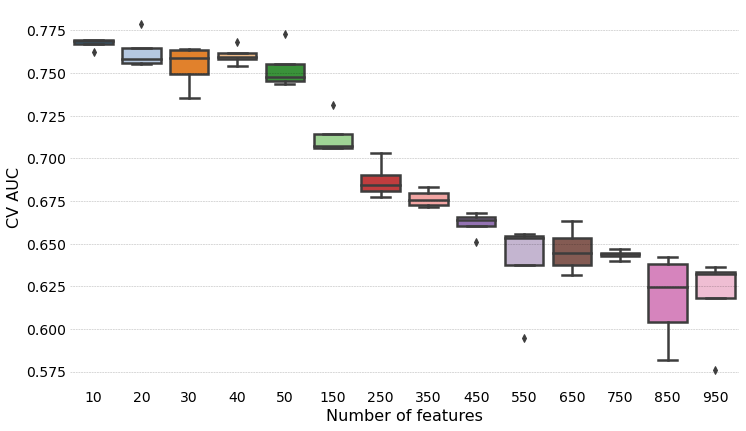

In [43]:
with plt.style.context('tableau20'):
    sb.boxplot(data=featurelist_performances_df)
    plt.ylabel('CV AUC')
    plt.xlabel('Number of features')

## Plot: Pareto front of median model performance vs. featurelist size

''

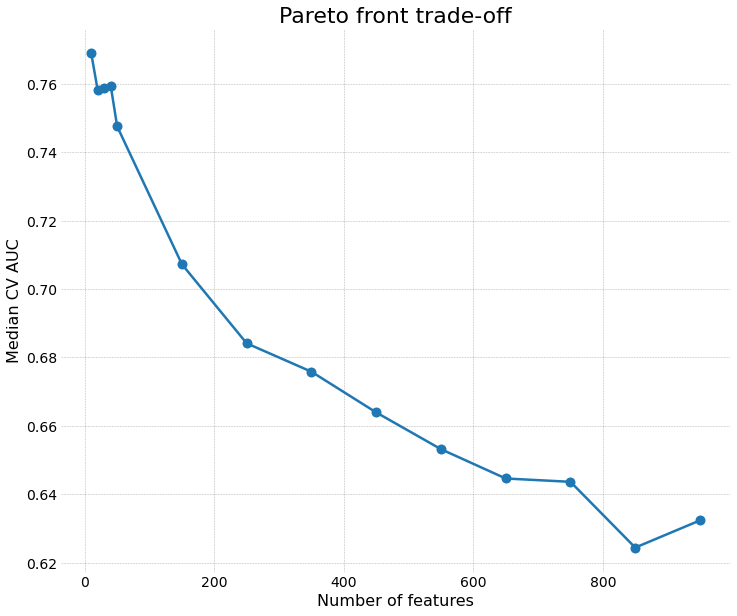

In [44]:
with plt.style.context('tableau10'):
    plt.figure(figsize=(12, 10))
    feature_nums = featurelist_performances_df.median().index.values
    medians = featurelist_performances_df.median().values
    plt.plot(feature_nums, medians, 'o-')

    plt.ylabel('Median CV AUC')
    plt.xlabel('Number of features')
    plt.title('Pareto front trade-off')

## Demo take-aways

* Even when passing "only" 1,000 features (out of the original 425,000 features), substantial performance gains were achieved by continuing to reduce the featurelist size in an automated fashion (i.e., parsimony analysis).
* By default, DataRobot does not perform parsimony analysis. At best, DataRobot suggests a reduced featirelist using one round of model-based feature importance from a single model.
* Integrating parsimony analysis into DataRobot promises to improve prediction accuracy for users who work with very "wide" datasets.